Library

In [1]:
# -*- coding: utf-8 -*-
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons, make_circles

# use gp_minimize to do optimisation
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
#from skopt.plots import plot_histogram, plot_objective_2D
from skopt.utils import use_named_args


Create test dataset

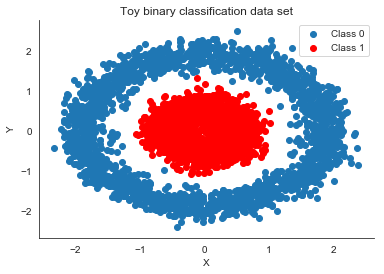

In [2]:
X, Y = make_circles(noise=0.1, factor=0.3, random_state=1, n_samples=4000, shuffle=True)
#X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

#Model Creation functioin

In [3]:

# model creation function
def construct_nn(ann_input, ann_output, num_dense_nodes):
    n_hidden = num_dense_nodes

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1,
                                 shape=(X.shape[1], n_hidden),
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1,
                                  shape=(n_hidden,),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.sigmoid(pm.math.dot(ann_input,
                                         weights_in_1))
        act_2 = pm.math.sigmoid(pm.math.dot(act_1,
                                         weights_1_2))
#        act_2 = pm.math.tanh(pm.math.dot(act_1,
#                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2,
                                              weights_2_out))
#        act_out = pm.math.sigmoid(pm.math.dot(act_1,
#                                              weights_2_out))
        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out',
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network


# Setup hyperparameter search space

In [13]:
#### HYPER PREM TUNNING #####
# only change the number of nodes in each layer
dim_num_dense_nodes  = Integer(low=2, high=40, name='num_dense_nodes')
dimensions = [dim_num_dense_nodes]

In [14]:
# best accuracy will be updated with higher ones during the hyperparameter selection
best_accuracy  = 0.0

# keep a list of tried parameter
parameter_hist = []

# keep a list of accuracy hist
acc_hist = []


In [21]:
# creat fitness fucntion
# fitness function will evaluate the model performence for current parameter selection and return the -accuracy
@use_named_args(dimensions=dimensions)
def fitness(num_dense_nodes):
    # show current hyper prem
    print('\nnum_dense_nodes:', num_dense_nodes)
    ann_input = theano.shared(X_train)
    ann_output = theano.shared(Y_train)
   # Create the neural network with these hyper-parameters.
    nn_model = construct_nn(ann_input, ann_output, num_dense_nodes=num_dense_nodes)



    with nn_model:
        #inference = pm.ADVI()
        #approx = pm.fit(n=3000, method=inference)
        step = pm.Metropolis()
        trace = pm.sample(2000, step=step)


    ann_input.set_value(X_test)
    ann_output.set_value(Y_test)

    # Creater posterior predictive samples
    ppc = pm.sample_ppc(trace, model=nn_model, samples=2000)
    pred = ppc['out'].mean(axis=0) > 0.5
    
    model_accurcy = (Y_test == pred).mean() * 100
    print('Accuracy = {}%'.format(model_accurcy))
    
    # save parameter and accuracy history
    parameter_hist.append(num_dense_nodes)
    acc_hist.append(model_accurcy)
    
    global best_accuracy
    # If the classification accuracy of the saved model is improved ...
    if model_accurcy > best_accuracy:
        # Update the classification accuracy.
        best_accuracy = model_accurcy

    return -model_accurcy

In [22]:
# default parameter is 2 nodes per layer
default_parameters = [2]

# We use Bayesian Optimization with gaussian process

In [23]:
# start searching hyper parameter with gp
# we will do 11 call of fitness function, start with default parameters
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=11,
                            x0=default_parameters)


num_dense_nodes: 2


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
Sampling 4 chains: 100%|█████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 678.78draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.13it/s]


Accuracy = 67.35%

num_dense_nodes: 29


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
Sampling 4 chains: 100%|█████████████████████████████████████████████████████| 10000/10000 [01:19<00:00, 126.04draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:35<00:00, 55.63it/s]


Accuracy = 99.95%

num_dense_nodes: 3


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
Sampling 4 chains: 100%|█████████████████████████████████████████████████████| 10000/10000 [00:16<00:00, 588.54draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.51it/s]


Accuracy = 67.15%

num_dense_nodes: 6


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
Sampling 4 chains: 100%|█████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.61draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 72.98it/s]


Accuracy = 99.9%

num_dense_nodes: 36


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
Sampling 4 chains: 100%|█████████████████████████████████████████████████████| 10000/10000 [01:34<00:00, 105.83draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:38<00:00, 52.12it/s]


Accuracy = 99.95%

num_dense_nodes: 13


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
Sampling 4 chains: 100%|█████████████████████████████████████████████████████| 10000/10000 [00:42<00:00, 234.63draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:30<00:00, 57.20it/s]


Accuracy = 100.0%

num_dense_nodes: 8


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
Sampling 4 chains: 100%|█████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 355.06draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 71.40it/s]


Accuracy = 99.75%

num_dense_nodes: 32


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
Sampling 4 chains: 100%|█████████████████████████████████████████████████████| 10000/10000 [01:24<00:00, 117.79draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:37<00:00, 53.28it/s]


Accuracy = 100.0%

num_dense_nodes: 36


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
Sampling 4 chains: 100%|█████████████████████████████████████████████████████| 10000/10000 [01:36<00:00, 104.12draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:38<00:00, 47.47it/s]


Accuracy = 100.0%

num_dense_nodes: 8


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
Sampling 4 chains: 100%|█████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 356.64draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 72.29it/s]


Accuracy = 99.95%

num_dense_nodes: 4


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
Sampling 4 chains: 100%|█████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 540.71draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.02it/s]


Accuracy = 99.75%


Text(0.5,1,'Result')

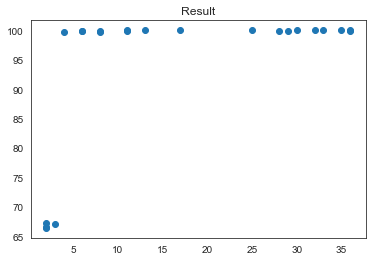

In [24]:

plt.scatter(parameter_hist, acc_hist)
plt.title('Result')
